# Epsilon-Greedy Policy

In _RecoGym_, all previous studies were concentrated on _Exploit_ Selection Policy. This Notebook dedicated to the analysis of the _`Agent`_ behaviour when the _`Agent`_ uses _**both**_ _Exploit_ **and** _Explore_ Selection Policies. Here, the simplest one _Explore_/_Exploit_ Selection Policy is applied: _Epsilon-Greedy_.


The policy will be approbated for the following _`Agents`_:
* _**`Bandit Count`**_: the _`Agent`_ that counts views of products and provides the most frequently viewed product as an _`Action`_.
* _**`Logistic Regression`**_: the _`Agent`_ that uses _Logistic Regression_ model to predict a click for an _`Action`_.
* _**`Logistic Regression with IPS`**_: the _`Agent`_ that utilises _Inverse Propensity Scores_ in training of _Logistic Regression_ model.

All the previously mentioned _`Agents`_ will be initialised with models trained on the same sample of data (logs).

In this study, you shall find the answers to these questions:
* How _Click-Through Rate_ evolves via using different values of $\varepsilon$ in different models through time?
* How the _Explore_ Policy Selection impacts in overall on the _Revenue_?

Finally,  an _`Agent`_ based on _**`Recoursive Neural Network`**_ will be analysed in _RecoGym_. This time, we will try to answer the question: how a more complex model can handle _RecoGym_  environment when _time_ starts influencing on _Organic_ and _Bandit_ events.

Below you shall find the code that initialises the environment.

In [1]:
import gym, reco_gym
from copy import deepcopy
from reco_gym import env_1_args
import matplotlib.pyplot as plt

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 4]

ABTestNumberOfUsers = 10000
RandomSeed = 42

NumberOfProducts = 10

env_1_args['random_seed'] = RandomSeed
env_1_args['num_products'] = NumberOfProducts
env_1_args['num_epochs'] = 100


env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

Through this notebook, we will work with the _`Agents`_ those are initialized as follows:

In [12]:
from reco_gym import Configuration

from agents import BanditMFSquare, bandit_mf_square_args
from agents import BanditCount, bandit_count_args
from agents import RandomAgent, random_args
from agents import NnIpsAgent, nn_ips_args
from agents import LogregPolyAgent, logreg_poly_args
from agents import EpsilonGreedy, epsilon_greedy_args
from agents import LogregMulticlassIpsAgent, logreg_multiclass_ips_args

agent_banditmfsquare = BanditMFSquare(Configuration({
    **env_1_args,
    **bandit_mf_square_args,
}))
agent_banditcount = BanditCount(Configuration({
    **env_1_args,
    **bandit_count_args,
}))
agent_rand = RandomAgent(Configuration({
    **env_1_args,
    **random_args,
}))
agent_nn_ips = NnIpsAgent(Configuration({
    **env_1_args,
    **nn_ips_args,
}))
agent_logreg_poly = LogregPolyAgent(Configuration({
    **env_1_args,
    **logreg_poly_args,
}))
agent_logreg_poly_ips = LogregPolyAgent(Configuration({
    **env_1_args,
    **logreg_poly_args,
    'with_ips': True,
}))
agent_logreg_multiclass_ips = LogregMulticlassIpsAgent(Configuration({
    **env_1_args,
    **logreg_multiclass_ips_args,
}))

# A list of Agents used in this Notebook to verify the evolution of CTR.
agents = {
    'LogReg Poly': agent_logreg_poly,
    'LogReg Poly IPS': agent_logreg_poly_ips,
#     'Bandit $MF^2$': agent_banditmfsquare,
#     'NN & IPS': agent_nn_ips,
}

## Advance Models in Time

As we are going to start using _Exploration_ Policy Selection in _`Agents`_, we should decide how models are to be updated/retrained with taking into account the data obtained during _Explorations_. Below you shall find three different approaches used for model retraining.

In [73]:
from enum import Enum

from reco_gym import TrainingApproach, EvolutionCase, evolute_agent
from scipy.stats.distributions import beta
import numpy as np


def generate_epsilons(epsilon_step = 0.01, iterations = 2):
    return [epsilon_step * k for k in range(iterations)]


def format_epsilon(epsilon):
    return "{0:.2f}".format(round(epsilon, 2))


def build_exploration_data(
        env,
        agents,
        training_approach,
        num_initial_train_users = 50,
        num_step_users = 50,
        num_evolution_steps = 5
):
    """
    A helper function that collects and draws data regarding Agents evolution
    under different values of epsilon for Epsilon-Greedy Selection Policy.

        :param env: The environment where evolution should be applied;
         every time when a new step of evolution is applied, the environment is deeply copied
         thus the Environment does not interferes with evolution steps.

        :param agents: A dictionary of Agents (Key => an instance of an Agent).

        :param training_approach:  A training approach applied in verification;
         for mode details look at `TrainingApproach' enum.

        :param num_initial_train_users: how many users' data should be used
         to train an initial model BEFORE evolution steps.

        :param num_step_users: how many users' data should be used
         at each evolution step.

        :param num_evolution_steps: how many evolution steps should be applied
         for an Agent with Epsilon-Greedy Selection Policy.

         :param max_agents_per_row: how many graphs should be drawn per a row

        :return a dictionary of Agent evolution statistics in the form:
            {
                'Agent Name': {
                    'Epsilon Values': {
                        EvolutionCase.SUCCESS: [an array of clicks (for each ith step of evolution)]
                        EvolutionCase.FAILURE: [an array of failure to draw a click (for each ith step of evolution)]
                    }
                }
            }
    """
    epsilons = generate_epsilons()

    # A dictionary that stores all data of Agent evolution statistics.
    # Key is Agent Name, value is statistics.
    agent_evolution_stats = dict()

    for (ix, agent_key) in enumerate(agents):
        agent_stats = dict()
        for epsilon in epsilons:
            epsilon_key = format_epsilon(epsilon)
            epsilon_greedy_agent = EpsilonGreedy(
                Configuration({
                    **epsilon_greedy_args,
                    **env_1_args,
                    'epsilon': epsilon,
                }),
                deepcopy(agents[agent_key])
            )
            rewards = reco_gym.evolute_agent(
                deepcopy(env),
                epsilon_greedy_agent,
                num_initial_train_users,
                num_step_users,
                num_evolution_steps,
                training_approach
            )

            agent_stats[epsilon_key] = {
                EvolutionCase.SUCCESS: rewards[EvolutionCase.SUCCESS],
                EvolutionCase.FAILURE: rewards[EvolutionCase.FAILURE],
                EvolutionCase.ACTIONS: rewards[EvolutionCase.ACTIONS]
            }
            assert (len(rewards[EvolutionCase.SUCCESS]) == len(rewards[EvolutionCase.FAILURE]))
            assert (len(rewards[EvolutionCase.SUCCESS]) == num_evolution_steps)

        agent_evolution_stats[agent_key] = agent_stats

    return agent_evolution_stats


def plot_evolutions(
    agent_evolution_stats,
    max_agents_per_row = 2
):
    epsilons = generate_epsilons()
    figs, axs = plt.subplots(
        int(len(agents) / max_agents_per_row),
        max_agents_per_row,
        figsize = (16, 8),
        squeeze = False
    )
    labels = [format_epsilon(epsilon) for epsilon in epsilons]

    for (ix, agent_key) in enumerate(agent_evolution_stats):
        ax = axs[int(ix / max_agents_per_row), int(ix % max_agents_per_row)]
        agent_evolution_stat = agent_evolution_stats[agent_key]
        
        ctr_means = []
        for epsilon in epsilons:
            epsilon_key = format_epsilon(epsilon)
            evolution_stat = agent_evolution_stat[epsilon_key]
            
            steps = []
            
            ms = []
            q0_025 = []
            q0_975 = []
            
            assert(len(evolution_stat[EvolutionCase.SUCCESS]) == len(evolution_stat[EvolutionCase.FAILURE]))
            for step in range(len(evolution_stat[EvolutionCase.SUCCESS])):
                steps.append(step)
                successes = evolution_stat[EvolutionCase.SUCCESS][step]
                failures = evolution_stat[EvolutionCase.FAILURE][step]
            
                ms.append(beta.ppf(0.5, successes + 1, failures + 1))
                q0_025.append(beta.ppf(0.025, successes + 1, failures + 1))
                q0_975.append(beta.ppf(0.975, successes + 1, failures + 1))
            
            ctr_means.append(np.mean(ms))

            ax.fill_between(
                range(len(steps)),
                q0_975,
                q0_025,
                alpha=.05
            )
            ax.plot(steps, ms)
            
        ctr_means_mean = np.mean(ctr_means)
        ctr_means_div = np.sqrt(np.var(ctr_means))
        ax.set_title(
            f"Agent: {agent_key} "
            + "("
            + "$\hat{\mu}_{CTR}="
            + "{0:.5f}".format(round(ctr_means_mean, 5))
            + "$, "
            + "$\hat{\sigma}_{CTR}="
            + "{0:.5f}".format(round(ctr_means_div, 5))
            + "$"
            + ")"
        )
        ax.legend(labels)
        ax.set_ylabel('CTR')
        ax.set_ylim([0.0, 0.05])
        
    plt.show()


def plot_heat_actions(
    agent_evolution_stats,
    epsilon = 0.0,
    max_agents_per_row = 2
):
    figs, axs = plt.subplots(
        int(len(agents) / max_agents_per_row),
        max_agents_per_row,
        figsize = (16, 8),
        squeeze = False
    )
    
    for (ix, agent_key) in enumerate(agent_evolution_stats):
        ax = axs[int(ix / max_agents_per_row), int(ix % max_agents_per_row)]
        agent_evolution_stat = agent_evolution_stats[agent_key]
    
        epsilon_key = format_epsilon(epsilon)
        evolution_stat = agent_evolution_stat[epsilon_key]
        
        action_stats = evolution_stat[EvolutionCase.ACTIONS]
        total_actions = len(action_stats)
        heat_data = []
        for ix in range(total_actions):
            heat_data.append(action_stats[ix])
            
        heat_data = np.array(heat_data)
        im = ax.imshow(heat_data)
    
        ax.set_yticks(np.arange(total_actions))
        ax.set_yticklabels([f"{action_id}" for action_id in range(total_actions)])
        
        ax.set_title(f"Agent: {agent_key} ($\epsilon=${epsilon_key}) ")
        
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Clicks", rotation=-90, va="bottom")
    
    plt.show()

### Model Retraining: All Data

In this case, all samples obtained during _*both*_ _Exploration_ **and** _Explotation_ are used to retrain a _Model_.

**Note:** the training data used for the very first training of the Model are used as well.

In [49]:
stats_all_data = build_exploration_data(env, agents, TrainingApproach.ALL_DATA)

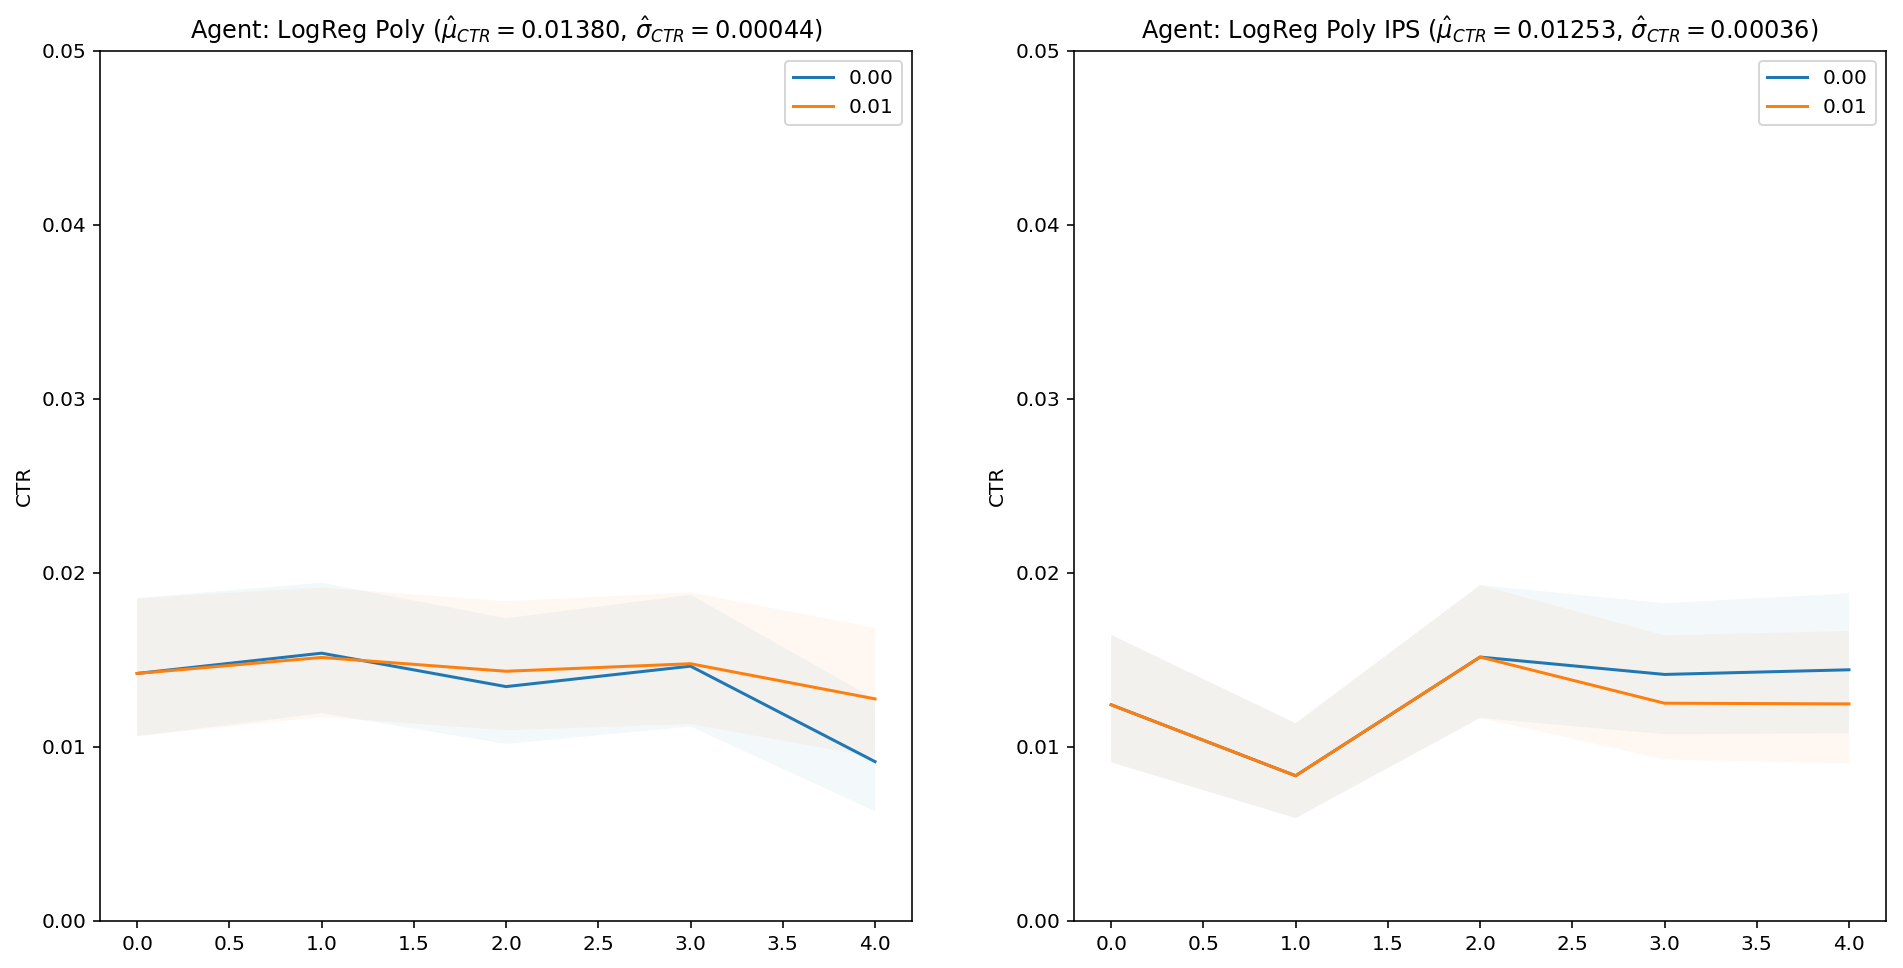

In [50]:
plot_evolutions(stats_all_data)

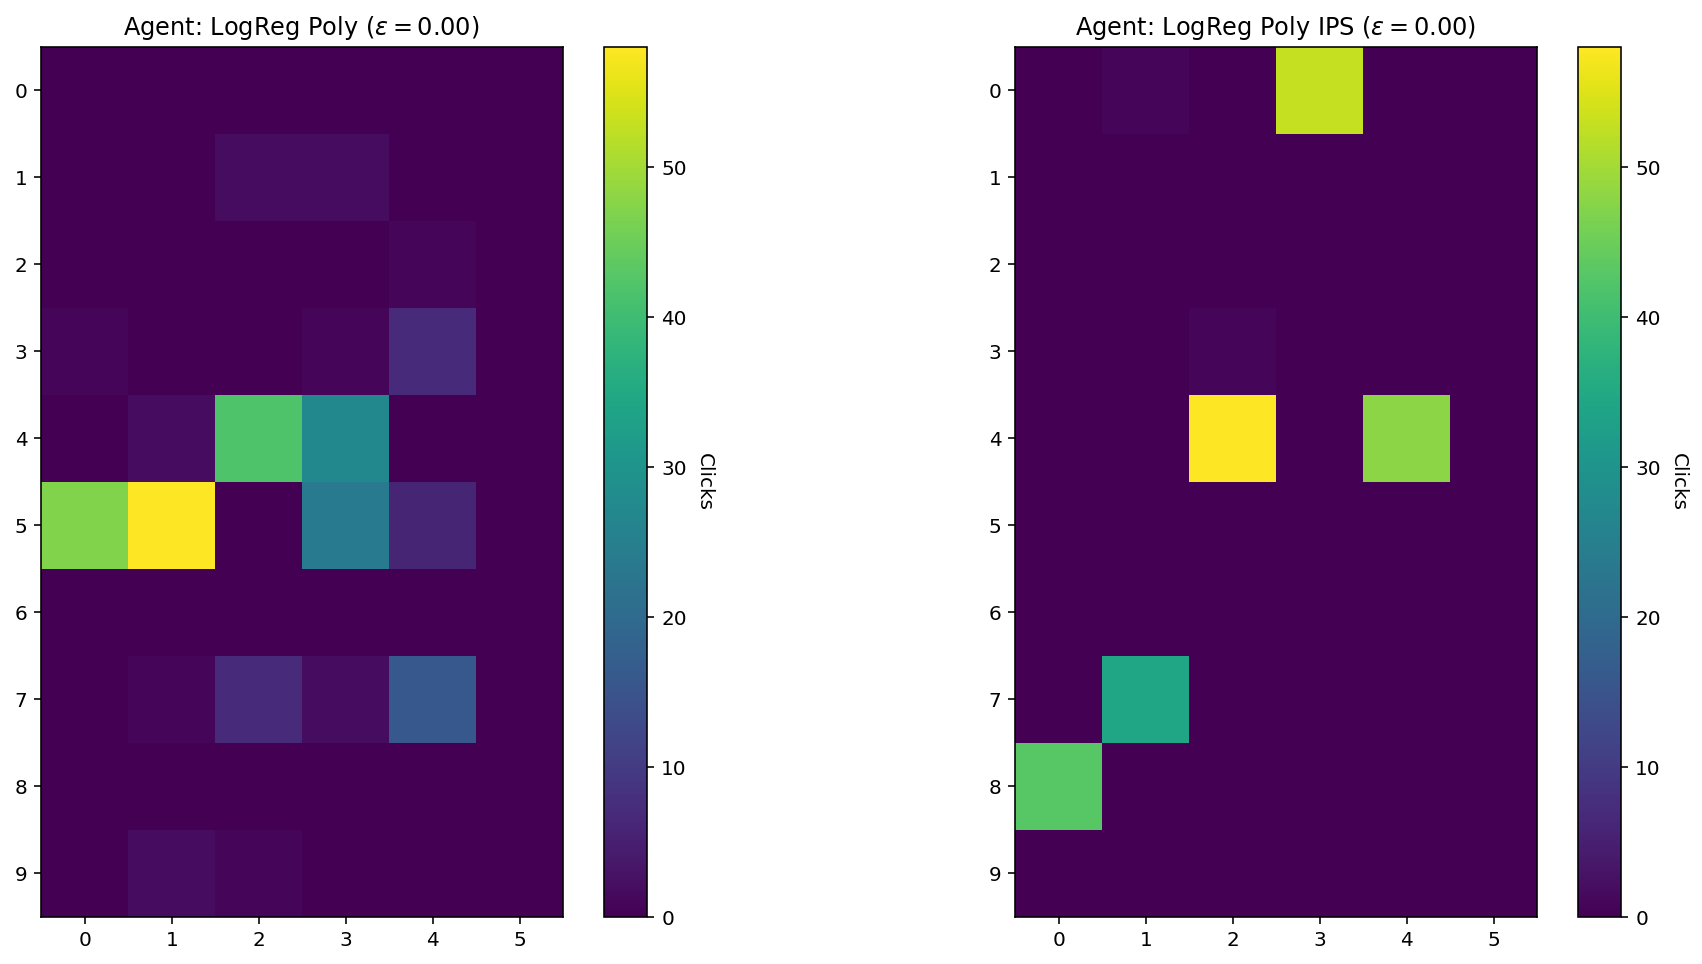

In [74]:
plot_heat_actions(stats_all_data)

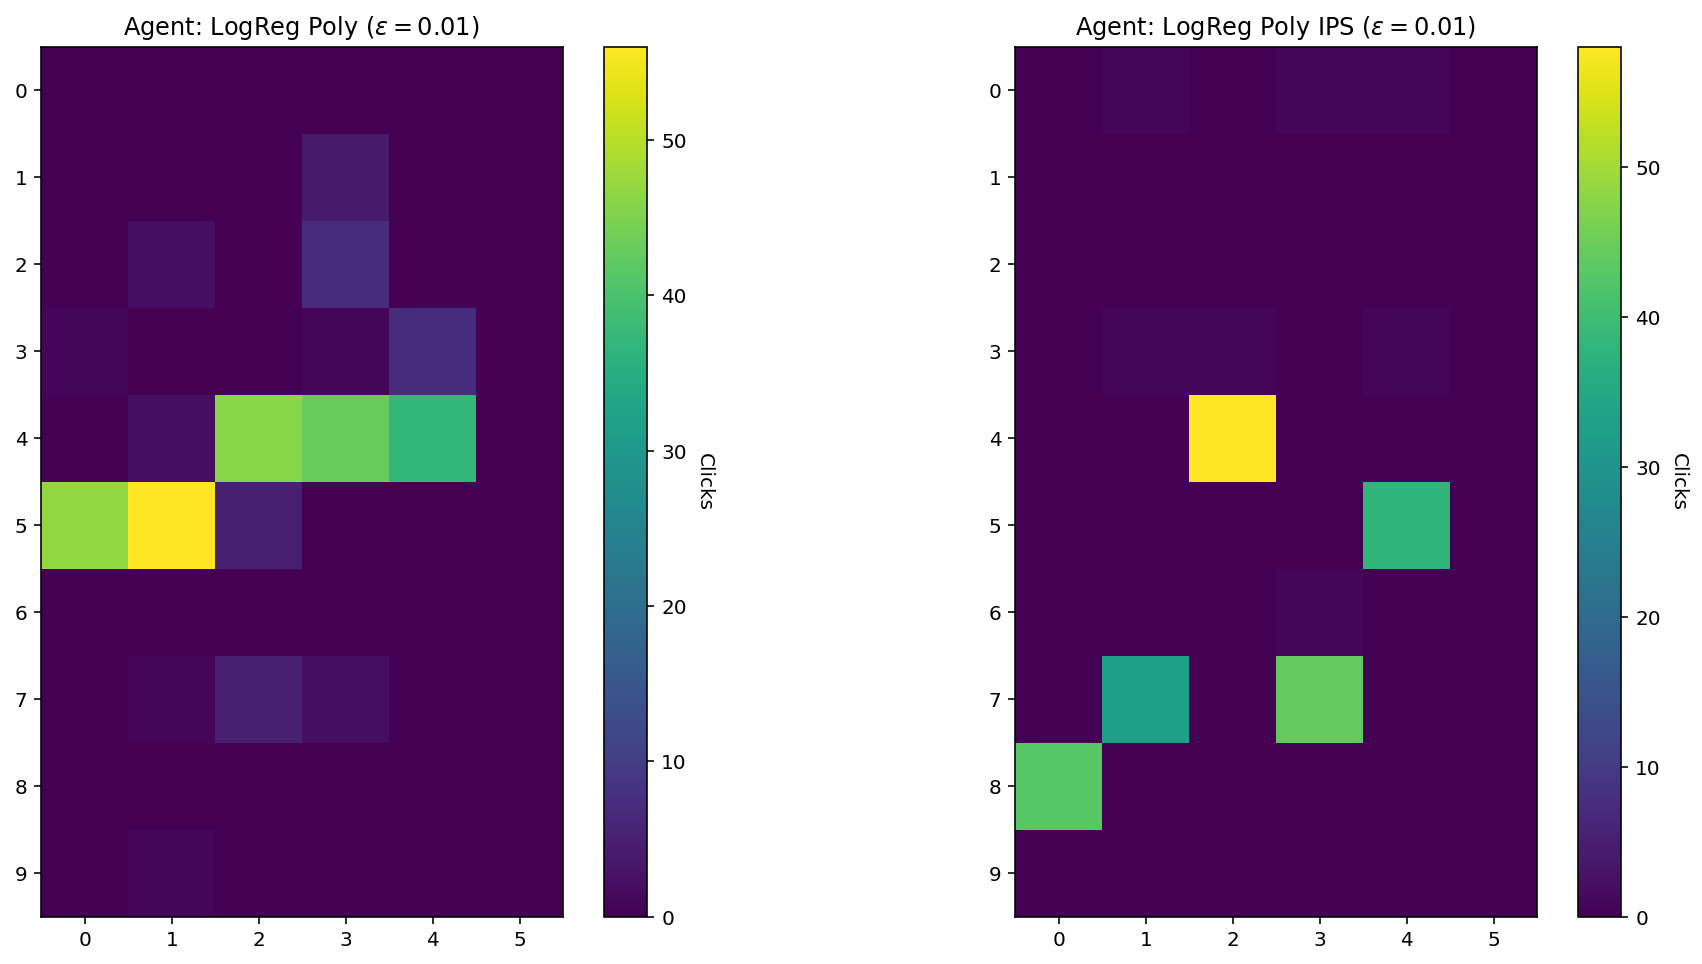

In [75]:
plot_heat_actions(stats_all_data, 0.01)

### Model Retraining: All _Exploration_ Data

In this case, a _Model_ is retrained with data obtained during _Epsilon_ Policy Selection.

**Note:** here, like in the previous example, the very first set of samples are used in training.

In [66]:
stats_all_explorations = build_exploration_data(env, agents, TrainingApproach.ALL_EXPLORATION_DATA)

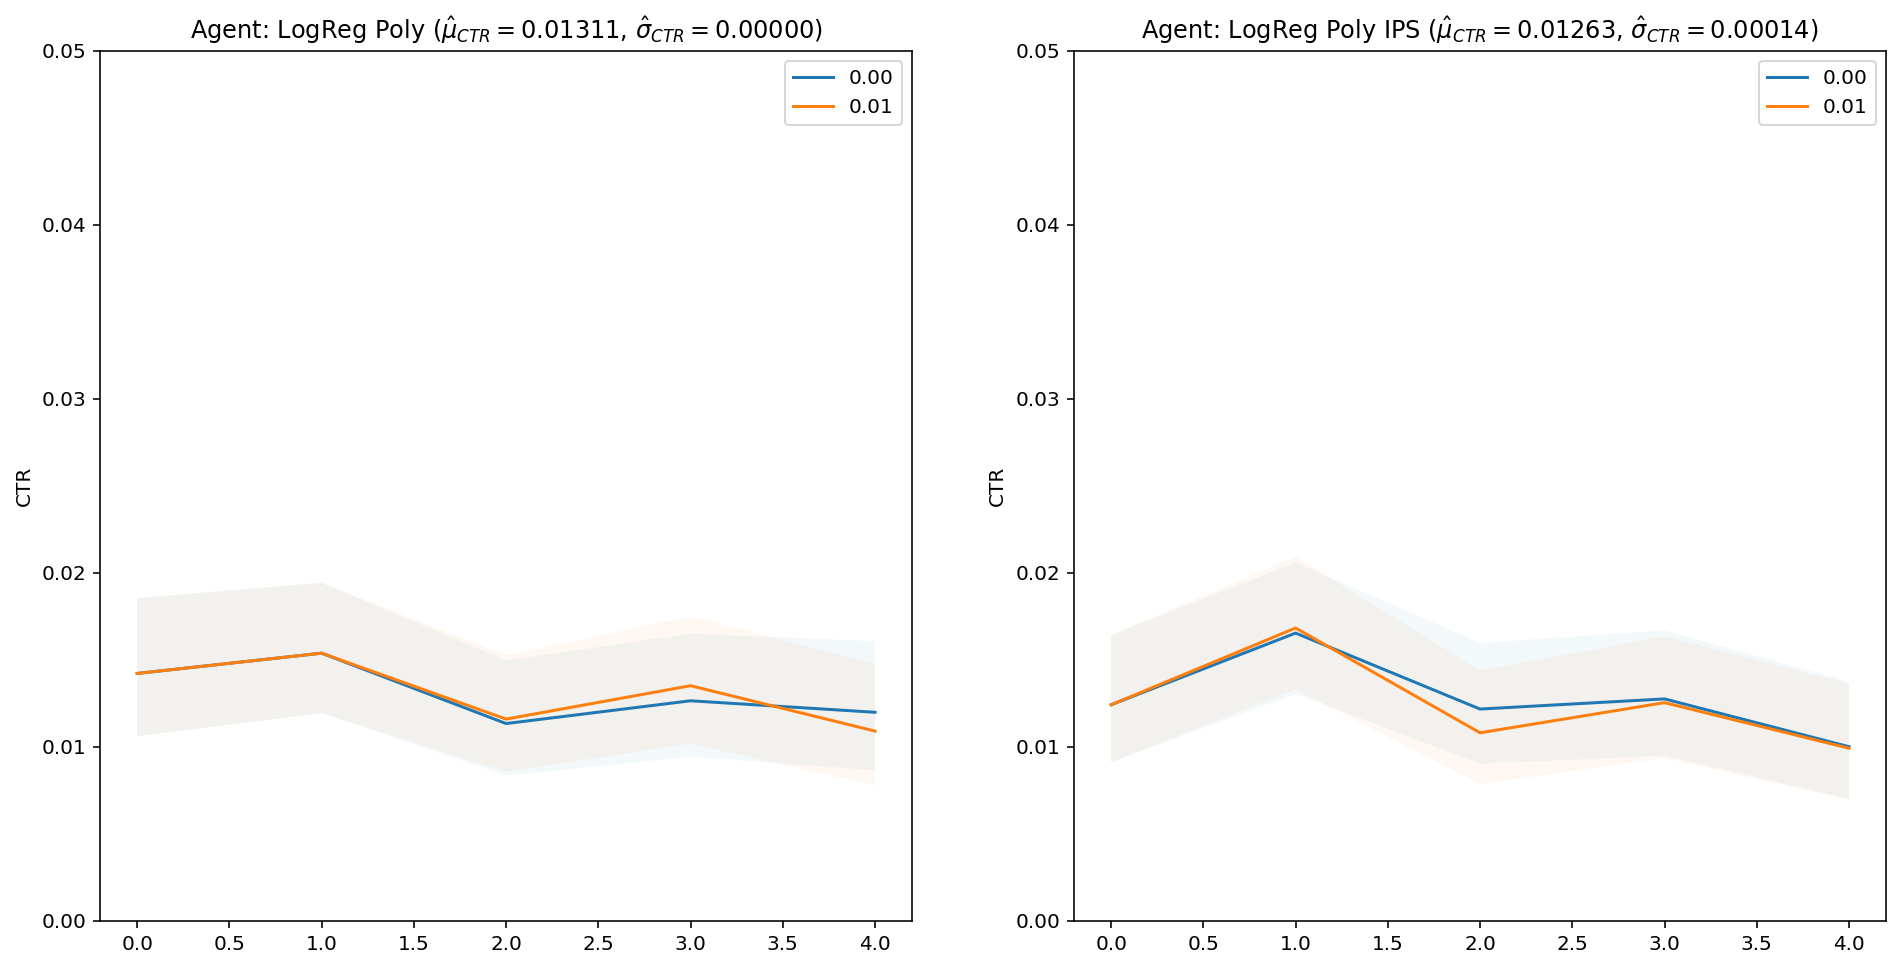

In [68]:
plot_evolutions(stats_all_explorations)

Because during each evaluation step, a volume of sample data grows, the _Models_ starts behaving better.

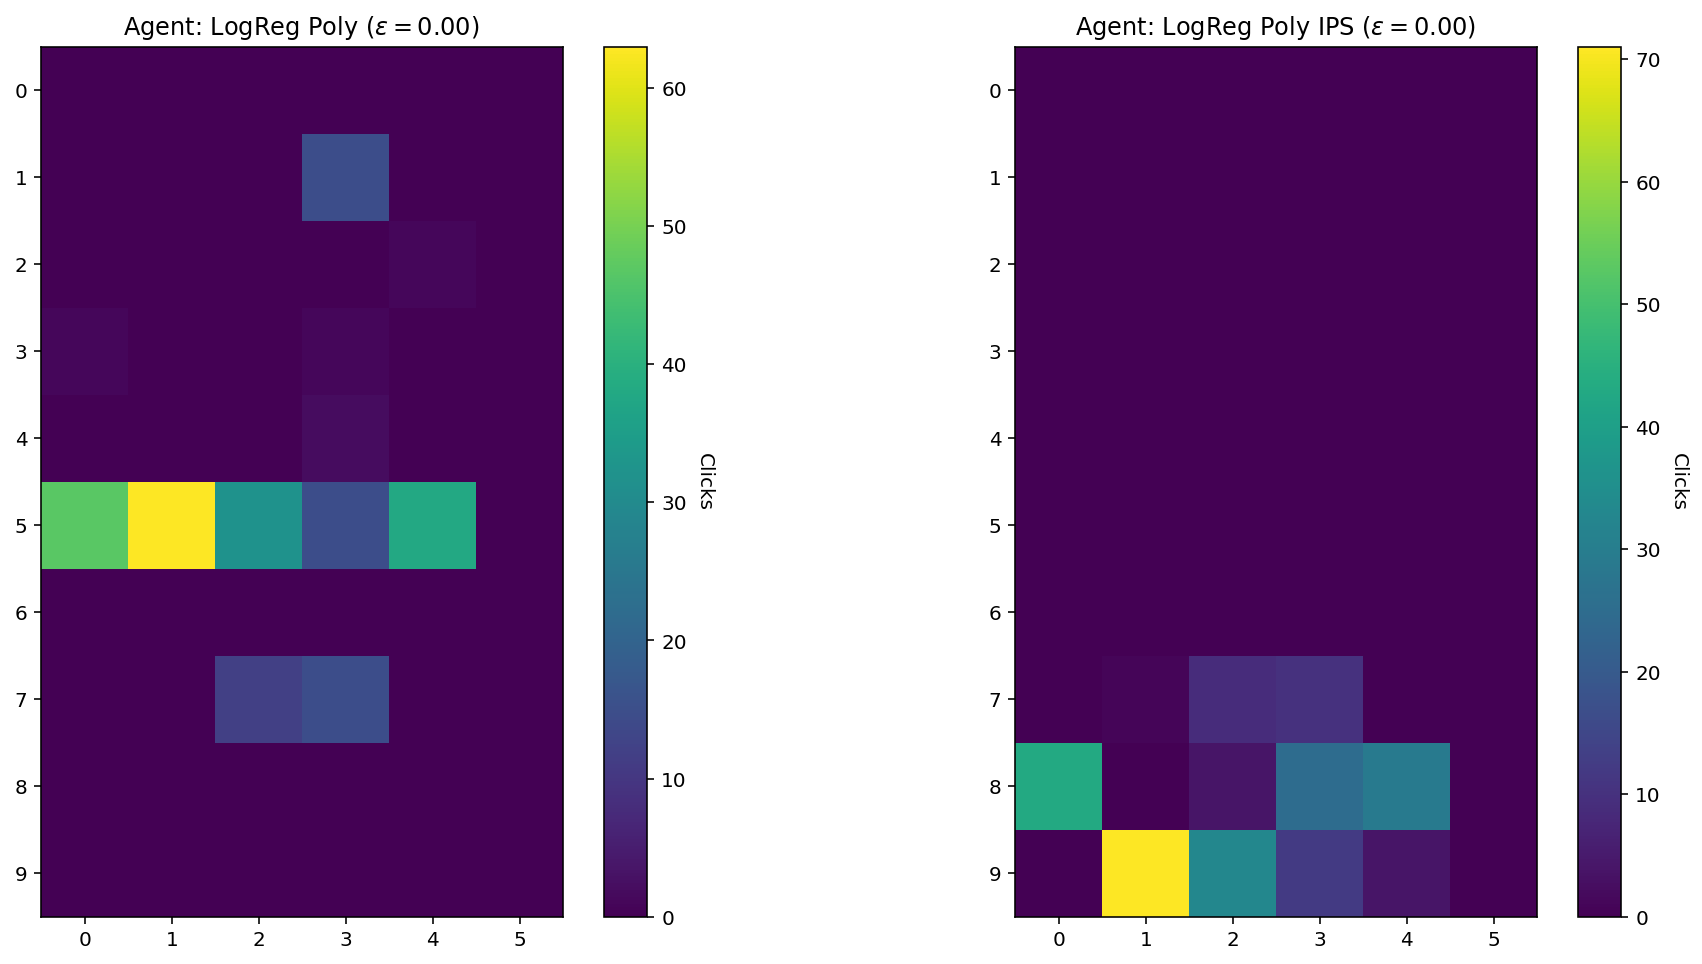

In [76]:
plot_heat_actions(stats_all_explorations)

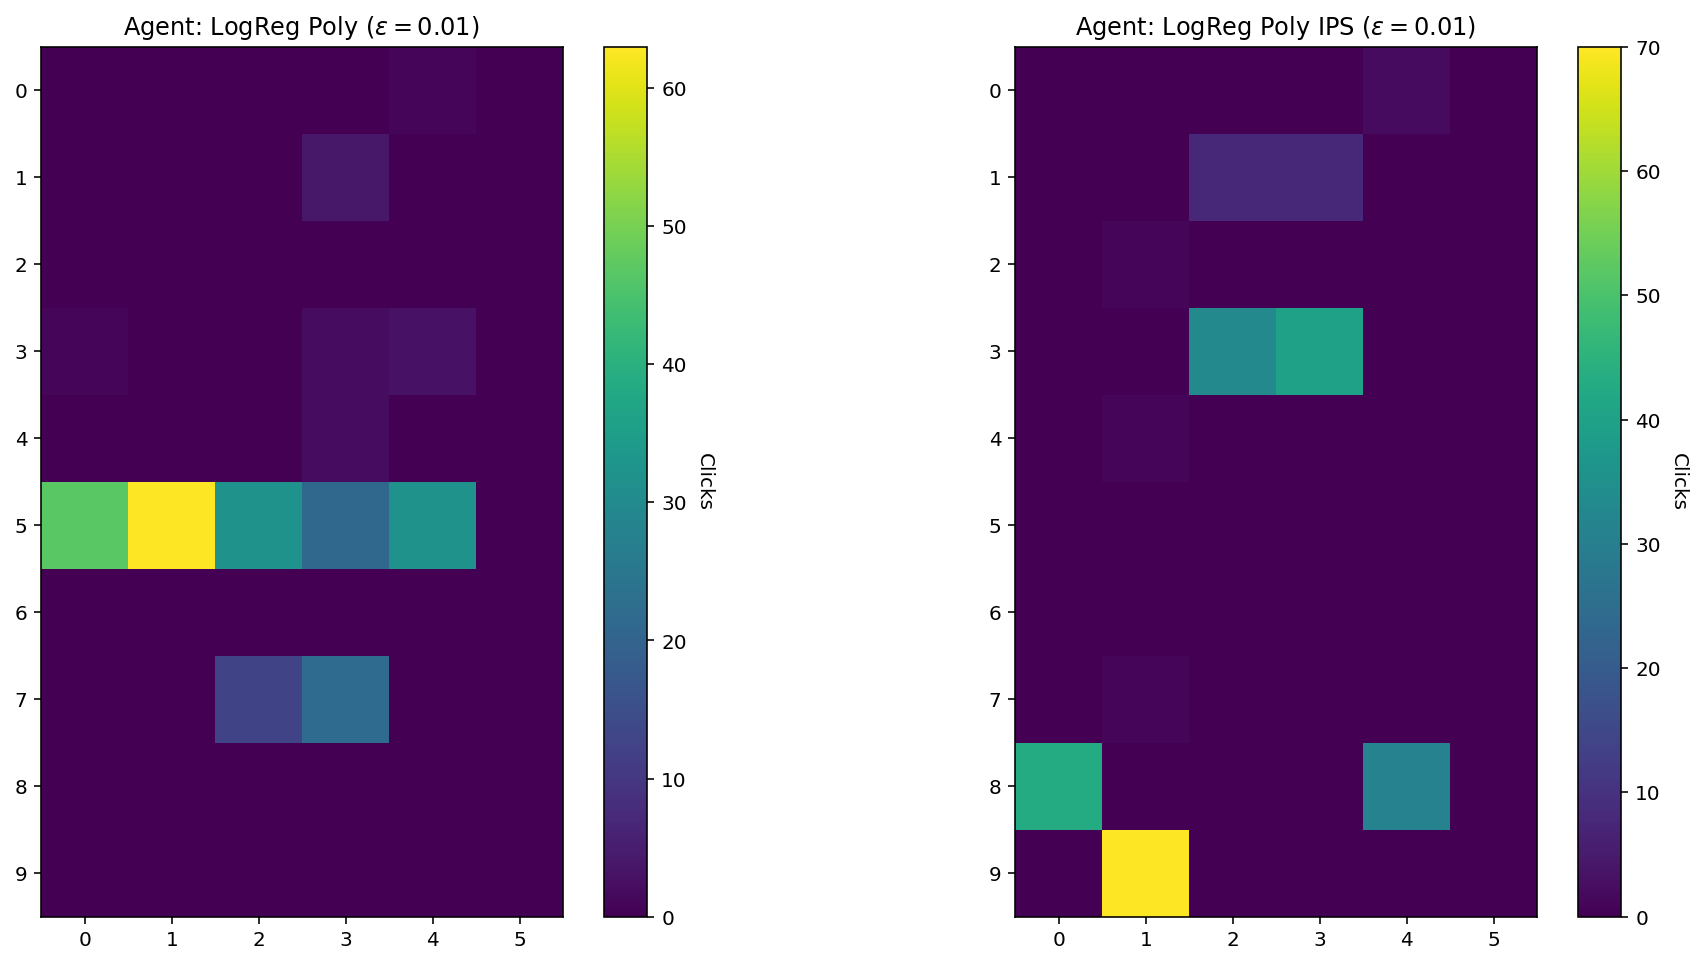

In [77]:
plot_heat_actions(stats_all_explorations, 0.01)

### Model Retraining: the _Latest_ Set of Data

In this case, a set of the latest samples of data is considered. I.e. a certain _**fixed**_ sliding window of training data samples are used to retrain models.

In [62]:
stats_last_steps = build_exploration_data(env, agents, TrainingApproach.LAST_STEP)

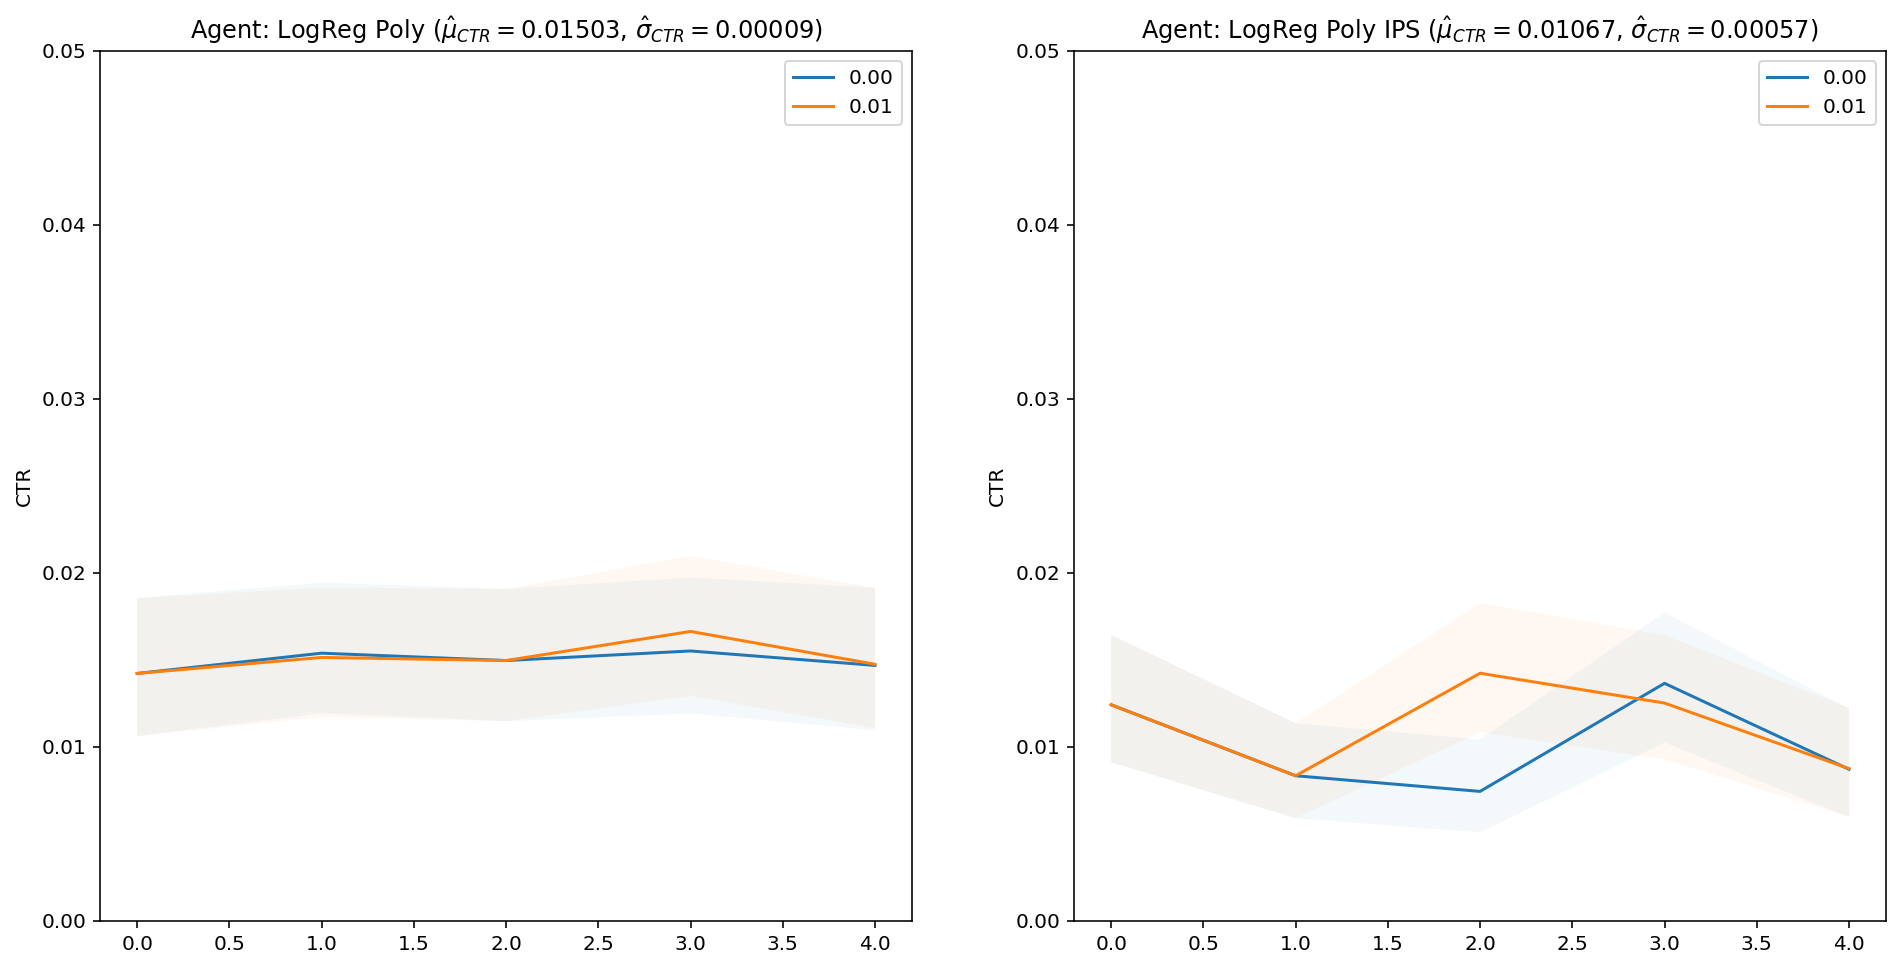

In [78]:
plot_evolutions(stats_last_steps)

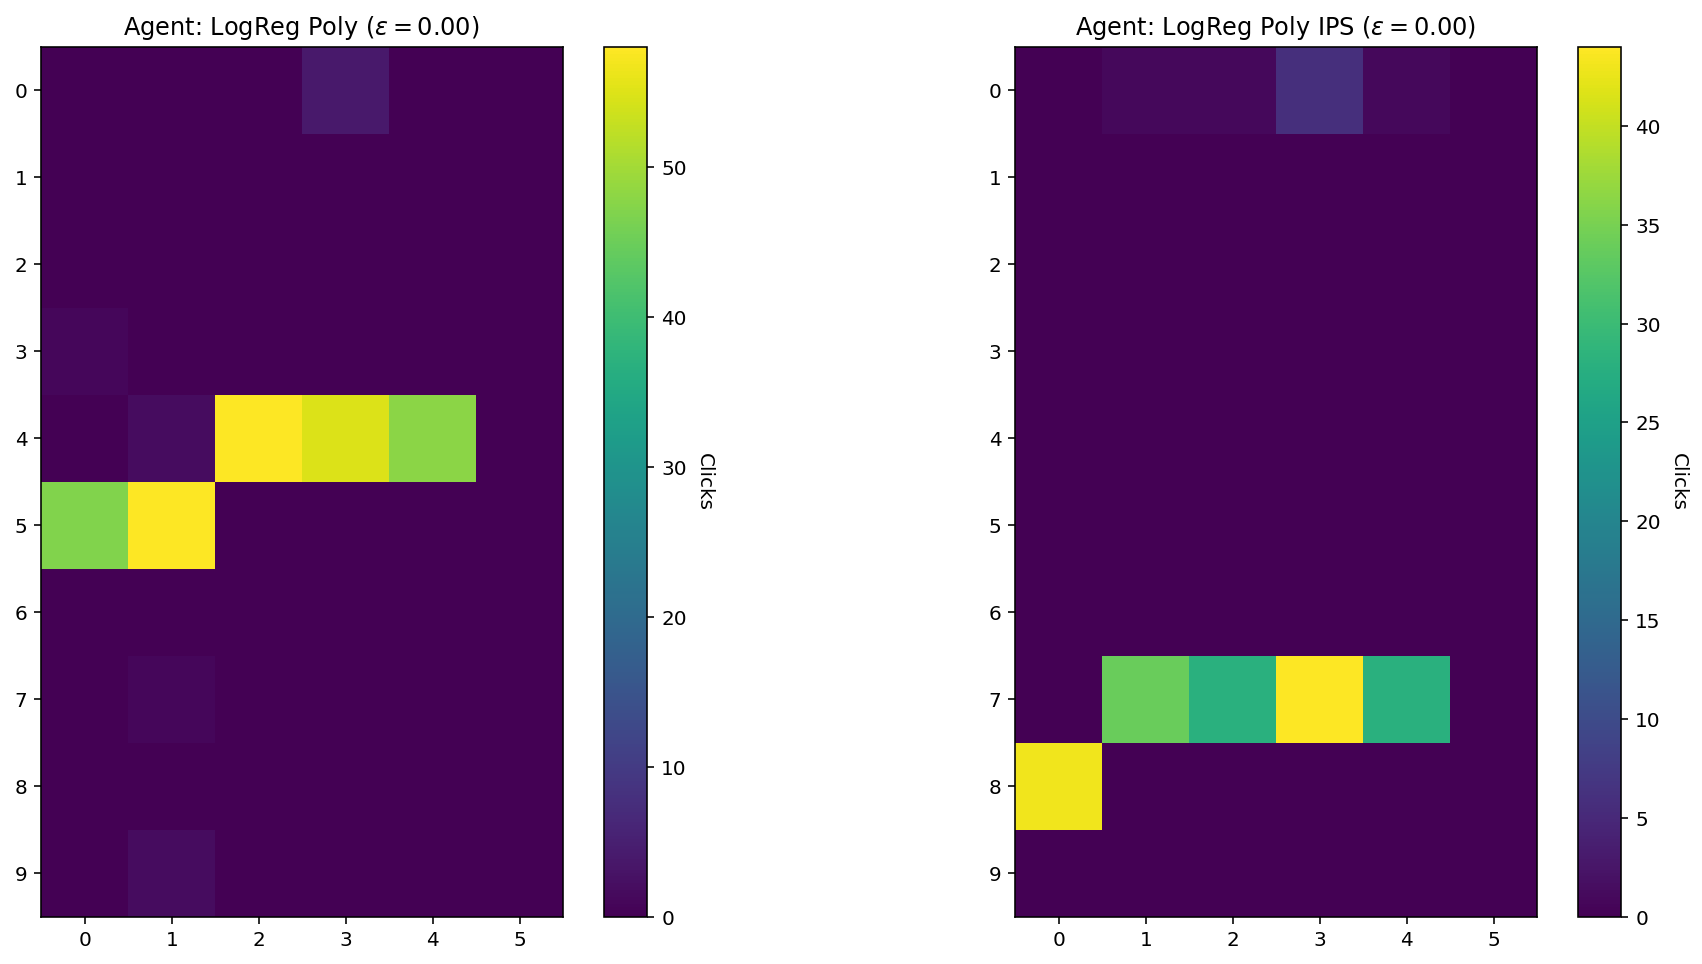

In [79]:
plot_heat_actions(stats_last_steps)

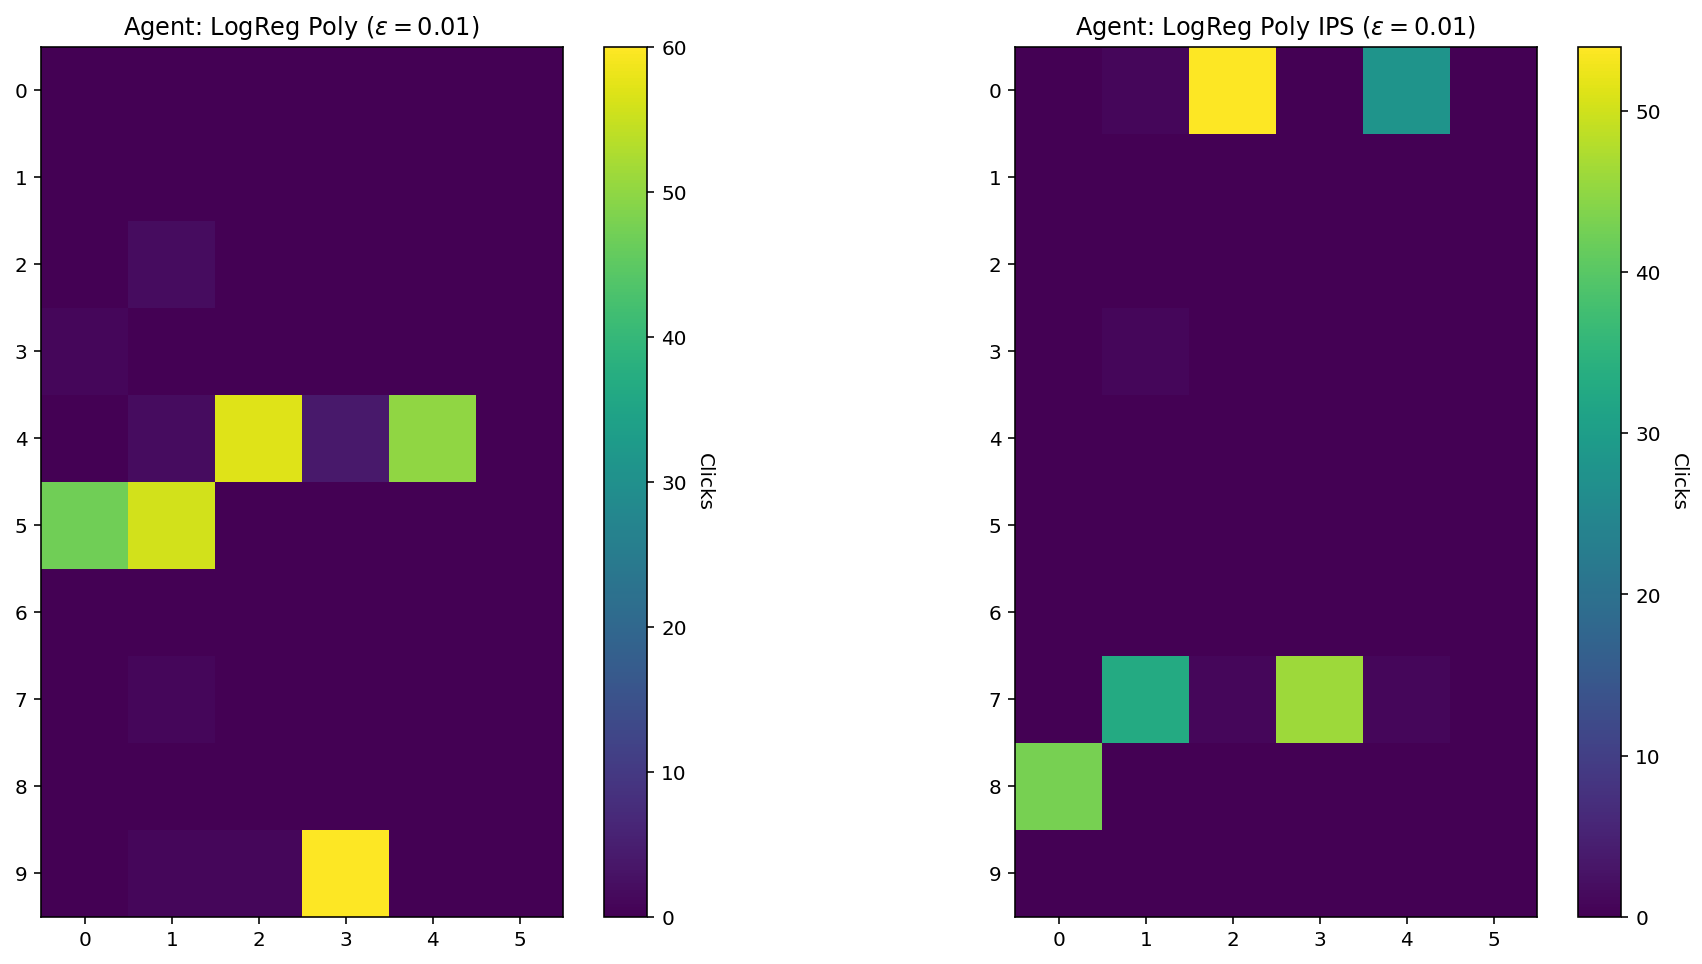

In [80]:
plot_heat_actions(stats_last_steps, 0.01)

## Exploration Amends

The performance of _`Agents`_ was considered _irrespectively_ to the price that was paid for the using of the _Exploration_ Selection Policy. This time, the impact of the utilising _Exploration_ Selection Policy is considered more _intently_. Therefore, _the price_ that is paid for the usage of the _Exploration_ Selection Policy is scrutinised to get insight about the benefit that is obtained when new data are incorporated in updated _Models_.

Also, the impact of applying _Exploration_ Selection Policy on _the state of the user_ is considered: it is estimated how that correlated with the case when only _Explotate_ Selection Policy would have been applied.

### Return of Investment

When _Explore_ Selection Policy is used then instead of using an _`Action`_ predicted by an _Old Model_, a _random_ _`Action`_ is provided. We _**definitely**_ pay a certain price by using _Exploration_ as usually a randomly selected _`Action`_ is used that is _**worse**_ than the _`Action`_ predicted by the _Old Model_. However, we consider that as an _Investment_ that might help us to get some earnings in a _long-term_ via getting more valuable training cases those would not have been available in the case when the _Old Model_ had been applied.


Thus, to estimate how efficient the _Investment_ is, it is evaluated via using _Return of Investment_ that is calculated as following:

$$ ROI_{t+1} = \frac{\sum \delta'_{i_{t+1}'} - \sum \delta_{i_{t+1}}}{\varepsilon \sum \delta_{i_{t}}} $$

* $
\delta_i =
\begin{cases}
    1,& \text{if there is a click}\\
    0,& \text{otherwise}
\end{cases}
$

The value of $\delta$ is calculated as if the _Old Model_ had been applied.

* $\delta'_{i'}$ is calculated via applying the _New Model_, i.e. the model that is created from the data obtained via usage of _Exploration_ Selection Policy.

* $\varepsilon \sum_i \delta_{i_{t}}$ is an estimated lost of applying Epsilon-Greedy Selection Policy.

**Note:** different indexes $i$ and $i'$ are used there as, in general, via using a different model, the states of the system will be different, thus amoung of _Bandit_ _`Events`_ will be different as well.

In [87]:
from enum import Enum


class Metrics(Enum):
    ROI = 0


def plot_roi(
        agent_evolution_stats,
        max_agents_per_row = 2
):
    """
    A helper function that calculates Return of Investment (ROI) for applying Epsilon-Greedy Selection Policy.

    :param agent_evolution_stats: statistic about Agent evolution collected in `build_exploration_data'.

         :param max_agents_per_row: how many graphs should be drawn per a row

    :return: a dictionary of Agent ROI after applying Epsilon-Greedy Selection Strategy in the following form:
        {
            'Agent Name': {
                'Epsilon Value': {
                    Metrics.ROI: [an array of ROIs for each ith step (starting from 1st step)]
                }
            }
        }
    """
    epsilons = generate_epsilons()
    figs, axs = plt.subplots(
        int(len(agent_evolution_stats) / max_agents_per_row),
        max_agents_per_row,
        figsize = (16, 8),
        squeeze = False
    )
    labels = [format_epsilon(epsilon) for epsilon in epsilons if epsilon != 0.0]

    agent_roi_stats = dict()

    for (ix, agent_key) in enumerate(agent_evolution_stats):
        ax = axs[int(ix / max_agents_per_row), int(ix % max_agents_per_row)]
        agent_stat = agent_evolution_stats[agent_key]
        zero_epsilon_key = format_epsilon(0)
        zero_epsilon = agent_stat[zero_epsilon_key]
        zero_success_evolutions = zero_epsilon[EvolutionCase.SUCCESS]
        assert (len(zero_success_evolutions))

        agent_stats = dict()
        roi_means = []
        for epsilon in generate_epsilons():
            if zero_epsilon_key == format_epsilon(epsilon):
                continue

            epsilon_key = format_epsilon(epsilon)
            agent_stats[epsilon_key] = {
                Metrics.ROI: [],
            }
            epsilon_evolutions = agent_stat[epsilon_key]
            success_evolutions = epsilon_evolutions[EvolutionCase.SUCCESS]
            failure_evolutions = epsilon_evolutions[EvolutionCase.FAILURE]
            assert (len(success_evolutions) == len(failure_evolutions))
            assert (len(zero_success_evolutions) == len(success_evolutions))
            steps = []
            rois = []
            for step in range(1, len(epsilon_evolutions[EvolutionCase.SUCCESS])):
                zero_success_evolution_pre = zero_success_evolutions[step - 1]
                zero_success_evolution = zero_success_evolutions[step]
                success_evolution = success_evolutions[step]

                predicted_lost = zero_success_evolution_pre * epsilon
                current_gain = success_evolution - zero_success_evolution
                roi = current_gain / predicted_lost

                steps.append(step)
                rois.append(roi)

                agent_stats[epsilon_key][Metrics.ROI].append(roi)

            roi_means.append(np.mean(agent_stats[epsilon_key][Metrics.ROI]))
            ax.plot(steps, rois)

        roi_means_mean = np.mean(roi_means)
        roi_means_div = np.sqrt(np.var(roi_means))
        ax.set_title(
            f"Agent ROI: '{agent_key}' "
            + "("
            + "$\hat{\mu}_{ROI}="
            + "{0:.5f}".format(round(roi_means_mean, 5))
            + "$, "
            + "$\hat{\sigma}_{ROI}="
            + "{0:.5f}".format(round(roi_means_div, 5))
            + "$"
            + ")"
        )
        ax.legend(labels)
        ax.set_ylabel('ROI')
#         ax.set_ylim([-5.0, +5.0])

        agent_roi_stats[agent_key] = agent_stats

    plt.show()
    return agent_roi_stats

#### Model Retraining: All Data

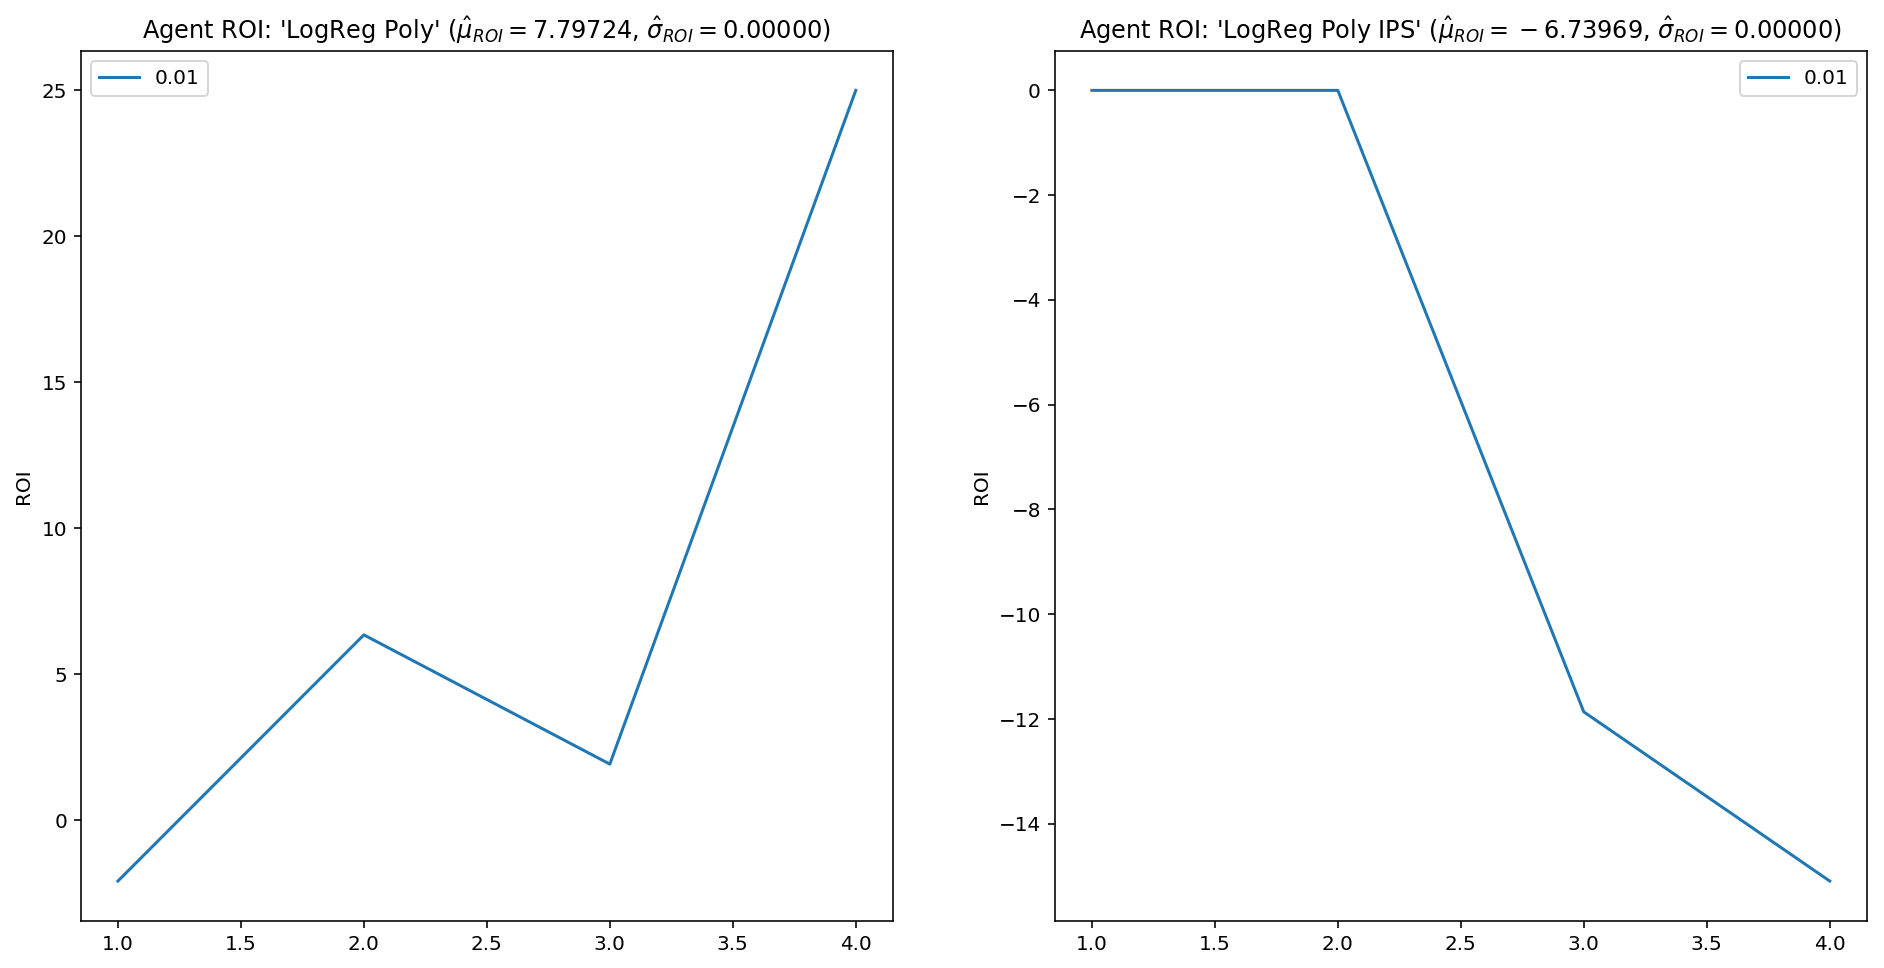

In [88]:
stats_roi_all_data = plot_roi(stats_all_data)

#### Model Retraining: All _Exploration_ Data

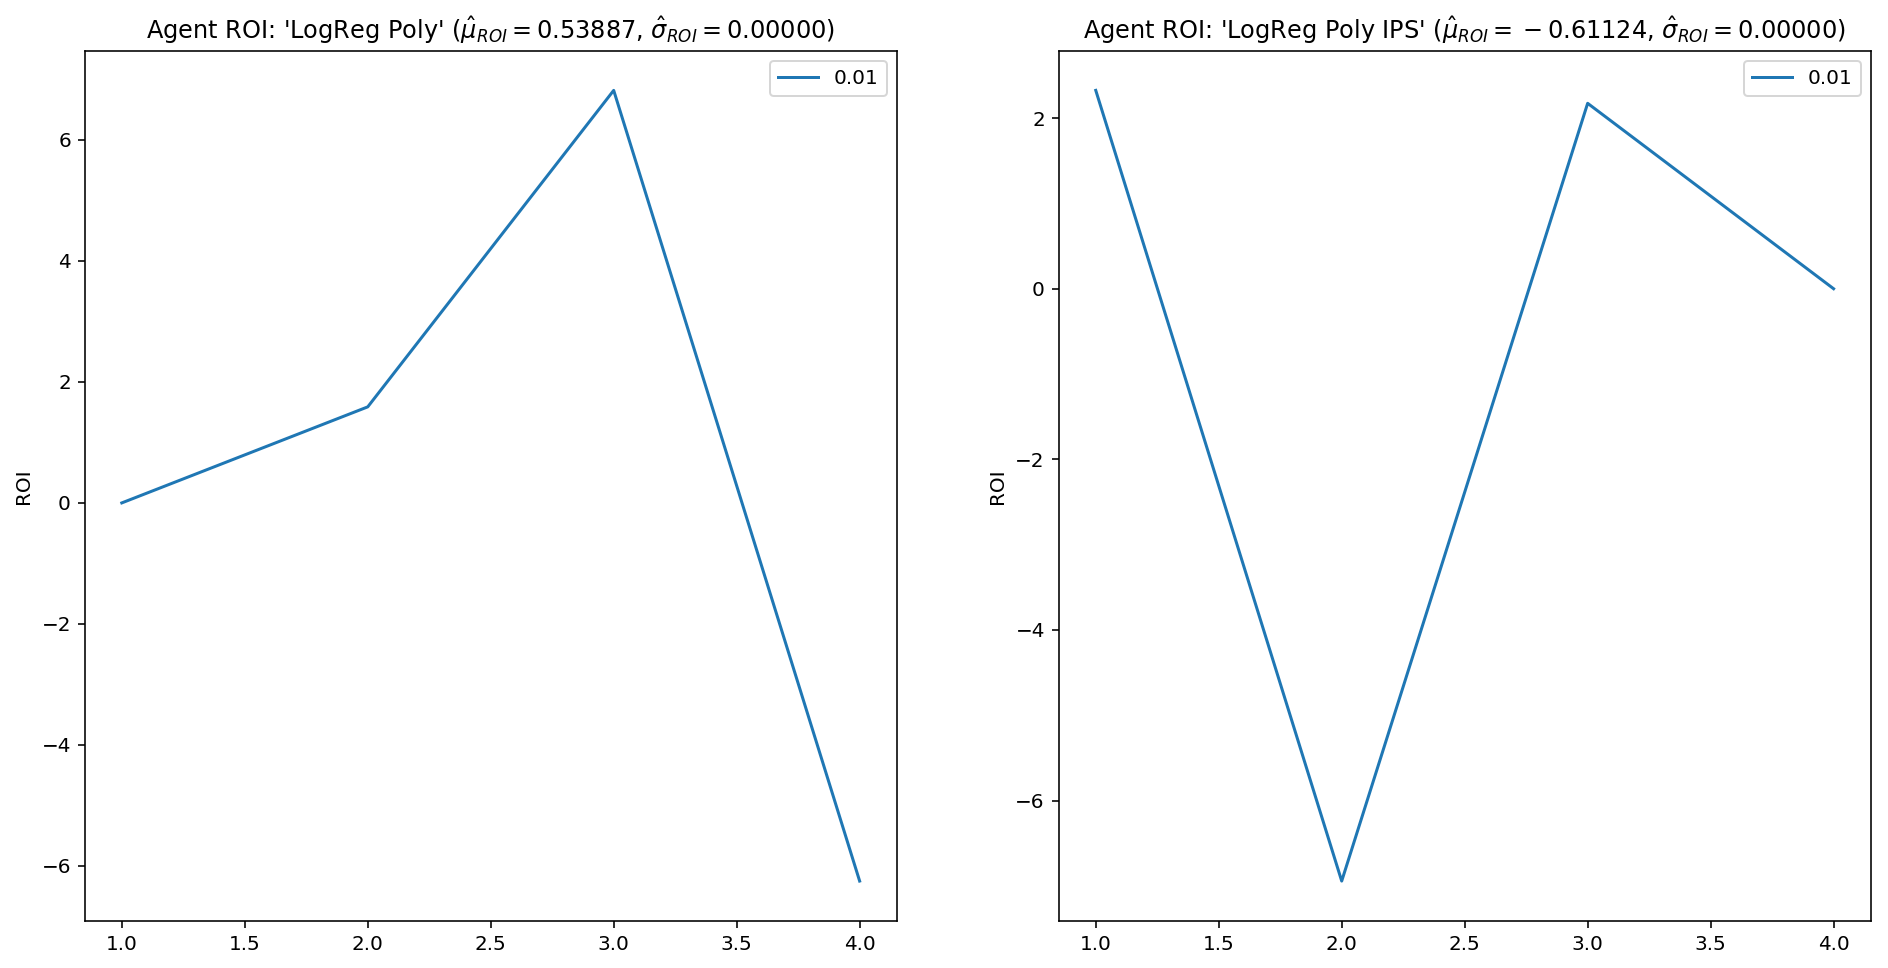

In [89]:
stats_roi_all_explorations = plot_roi(stats_all_explorations)

#### Model Retraining: the _Latest_ Set of Data

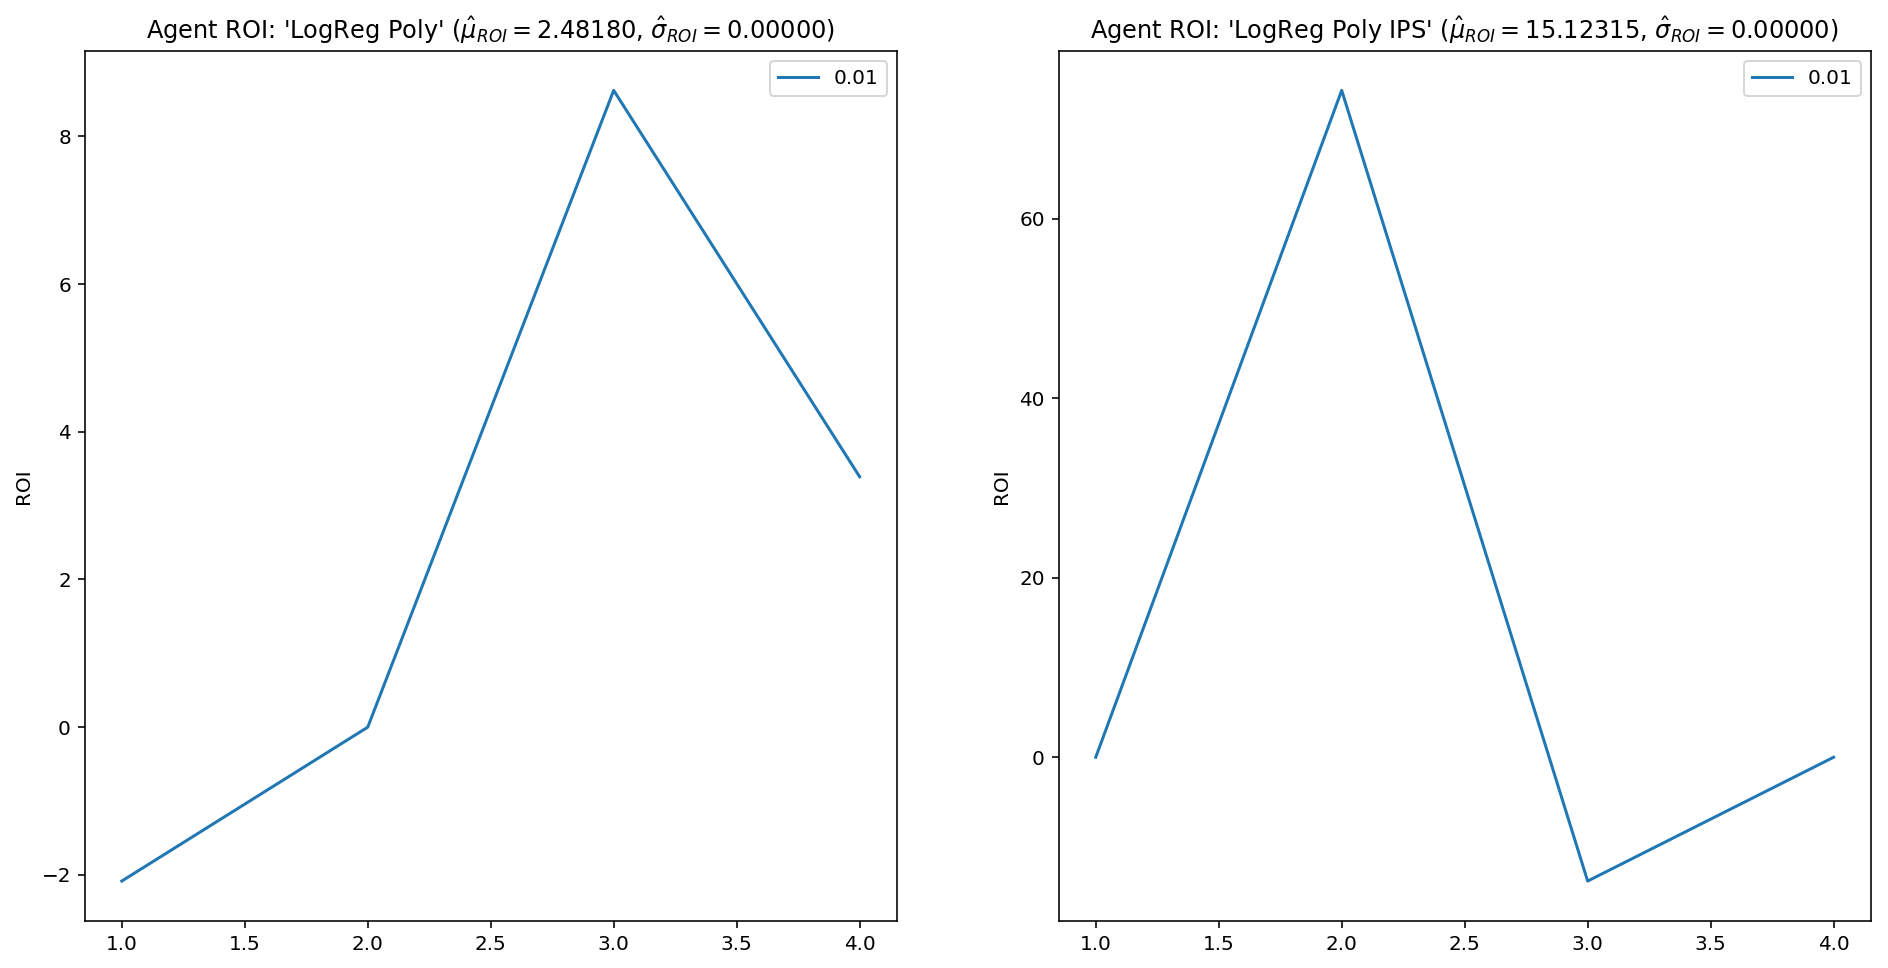

In [90]:
stats_roi_last_steps = plot_roi(stats_last_steps)

## The Impact of the _Exploration_ Selection Policy

Through the whole course of _RecoGym_, _Click-Through Rate_ was the only indicator of the _`Agent`_  performance. That approach was acceptable if the clicks are the only source of revenue. In reality, that is a bit complicated. In reality, _the Revenue Excluding Traffic Acquisition Costs_ (_Rev Ex TAC_) is used in Criteo as the prime estimator of the performance. That means, that even though we have not got a click, we have to pay for _an Impression_. Thus, the model should be optimised in the context of such objectives.

_Naïve_ _Rev Ex TAC_ is calculated as follows:

$$ RevExTAC = C_C - C_I$$

where
* $C_C$ is _**the Cost of the Click**_ or _the Revenue of the Click_
* $C_I$ is _**the Cost of the Impression**_ or _the Impression Cost_ i.e. the price of placing an add at publisher's site


Besides, when a certain _`Action`_ is applied, user's state is changed. That means that we ought to consider _`Actions`_ provided during _Exploration_ Selection Policy in that context.

# _Exploratoin_ in the Context of _Recoursive Neural Network_

Throughout the course or _RecoGym_, a set of previous _`Actions`_ in _Bandit_ _`Events`_ were _**not**_ considered in feature sets. This time, the previous _`Actions`_ will be incorporated into a model based on _Recoursive Neural Network_ (RNN).

The behaviour of _RNN_ model by using different $\varepsilon$ values.